# <font color=#531AC8>Fatoração de Matrizes para Sistemas de Classificação de Machine Learning</font>
> __Trabalho para a disciplina CCM0218 (2020.2)__ <br>
Fernando Valls Yoshida (11246714) e Lucas de Sousa Rosa (11296717)

Para a realização deste trabalho, nos reunimos periodicamente para ler o material fornecido, acompanhando as passagens e discutindo os pseudo-códigos. Enquanto isso, foi elaborado este Jupyter Notebook, em que constam os códigos que escrevemos, as considerações sobre eles e o relatório das tarefas exigidas. Na ordem natural em que aparecem no texto fornecido, os temas abordados virão neste documento.

__Seção para importação das bibliotecas__

In [64]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import time
from datetime import datetime
import re

## <font color=#C8531A>Primeira tarefa</font>

> Observação: em Álgebra Linear, é natural contar as posições de matrizes começando em 1, mas Numpy o faz começando em 0. Em face disso, aqui optou-se por manter a contagem da Álgebra sempre que possível. Em caso contrário, são feitas intervenções diretas no sistema de contagem, ou como ajuste geral (fazendo, e.g., $i = i - 1$ no início de um trecho de código) ou como ajuste de indexação no uso de um elemento da matriz (e.g., $W[i - 1, j - 1]$ para fazer $W_{i,j}$). Sempre que conveniente, tais medidas são apontadas no corpo do código.

A primeira tarefa trata da __resolução de sistemas lineares através da Fatoração QR__, em caso de sistemas sistemas sobredeterminados, individual (`solve`) e simultaneamente (`solve_multi`). Para ambos os casos, faz-se necessário implementar uma rotação de Givens $Q(i,j,\theta)$ (`rot_Givens`) que, por sua vez, depende de uma implementação de `cos_sin`, definido tal como no documento de referência.<br>
Estes quatro métodos encontram-se abaixo. As verificações de funcionamento de todos os métodos estão no __Apêndice__ deste documento.

__Determina os valores de cos(θ) e sin(θ), conforme (3) e (4)__

In [5]:
def cos_sin(W, i, j, k):
    # ajuste de contagem
    i = i - 1
    j = j - 1
    k = k - 1
    
    if abs(W[i,k]) > abs(W[j,k]):
        t = -W[j,k]/W[i,k]
        c = 1/math.sqrt(1 + t**2)
        s = c*t
    else:
        t = -W[i, k]/W[j, k]
        s = 1/math.sqrt(1 + t**2)
        c = s*t    
    return c, s

__Rotação de Givens Q(i, j, θ) a ser aplicada em $W_{n \times m}$__

In [6]:
def rot_Givens(W, n, m, i, j, c, s):
    # ajuste de contagem
    i = i - 1
    j = j - 1

    W[i,0:m], W[j,0:m] = c*W[i,0:m] - s*W[j,0:m], s*W[i,0:m] + c*W[j,0:m]

> Observação: Para `solve` e `solve_multi` há a construção de uma matriz resposta, que poderia ser retornada por cada um destes métodos. Porém, em se tratando tipicamente de matrizes com muitas dimensões, optou-se neste projeto por sobrescrever estes valores resultado na matriz da direita (a matriz $b$, em um sistema $W \cdot x = b$). Para isto, faz-se necessário provar que:<br>
(i) os valores para a definição de um elemento em $x$ não dependem de elementos anteriores em $b$ (que, sobrescritos, estariam perdidos) e<br>
(ii) a definição de $x_{j}$ não pode depender de valores de $x_{i}$, se, na ordem em que se avança o cálculo, j precede i (i.e., não se pode usar um elemento ainda não calculado).<br>
<br>
>No caso de `solve`, nota-se que, para<br>
$x_{k} = \left( b_{k} - \sum_{j=k+1}^{m}w_{k,j}x_{j} \right)/w_{k,k}$<br>
o valor de $b_{k}$ é usado uma única vez, e somente para a definição de $x_{k}$. Ainda, para a definição deste, usa-se $x_{j}$, com $m \leq j \leq k+1$ (e $k$ progride de $m$ a 1, logo estes são valores anteriores a $k$). É por este motivo, na linha do que inicialmente argumentado, que se pode sobrescrever $x$ em $b$.<br>
Analogamente, para `solve_multi` (um sistema $W \cdot H = A$), em que há<br>
$h_{k,j} = \left( a_{k,j} - \sum_{i=k+1}^{p}w_{k,i}h_{i,j} \right)/w_{k,k}$<br>
o valor $a_{k,j}$ é usado somente para a definição de $h_{k,j}$, tendo ainda que os $h_{i,j}$ usados têm $k+1 \leq i \leq p$ (e $k$ progride de $p$ a 1, logo estes valores de $i$ correspondem aos termos $k$ anteriores, já calculados) e $j$ é o mesmo do elemento calculado no momento ($h_{k,j}$). De maneira análoga, portanto, justifica-se a sobrescrita.<br>
<br>
Cabe ainda considerar que não necessariamente a matriz resultado e a matriz direita possuem as mesmas dimensões, motivo pelo qual, em um sistema genérico $W \cdot x = b$, $b$ sobrescrito possui os valores de $x$ somente nas posições em que se define $x$ e o demais valores não são de interesse. Esta consideração se manifesta doravante na seleção de trechos de $b$ para definir $x$ (e.g., se $x_{3 \times 1}$ se define a partir de $b_{5 \times 1}$, representa-se, no corpo do código, $x$ como `b[:4,:]`.

__Resolução de sistemas sobredeterminados__

In [7]:
def solve(W, b, n, m):
    eps = 10e-10       # zero
    for k in range(1, m + 1):
        for j in range(n, k, -1):
            i = j - 1
            if abs(W[j - 1, k - 1]) > eps:
                cos, sin = cos_sin(W, i, j, k)
                rot_Givens(W, n, m, i, j, cos, sin)
                rot_Givens(b, n, 1, i, j, cos, sin)
    
    for k in range(m, 0, -1):
        soma = 0
        for j in range(k + 1, m + 1):
            soma += W[k - 1, j - 1]*b[j - 1, 0]
        b[k - 1, 0] = (b[k - 1, 0] - soma)/W[k - 1, k - 1]

__Vários sistemas simultâneos__

In [8]:
def solve_multi(W, A, n, m, p):
    eps = 10e-10       # zero
    for k in range(1, p + 1):
        for j in range(n, k, -1):
            i = j - 1
            if abs(W[j - 1, k - 1]) > eps:
                cos, sin = cos_sin(W, i, j, k)
                rot_Givens(W, n, p, i, j, cos, sin)
                rot_Givens(A, n, m, i, j, cos, sin)
    
    for k in range(p, 0, -1):
        for j in range(1, m + 1):
            soma = 0
            for i in range(k+1,p+1):
                soma += W[k-1,i-1]*A[i-1,j-1]
            A[k-1,j-1] = (A[k-1,j-1] - soma)/W[k-1,k-1]

## Testes sugeridos

Dispõem-se abaixo os métodos associados à resolução de cada um dos testes sugeridos, que, por um lado, montam as matrizes-teste e, por outro, solucionam o sistema com os métodos já construídos na __Primeira Tarefa__. Para cada um dos testes, fez-se a devida verificação dos resultados com o `Octave` e estes dados encontram-se no __Apêndice__ deste documento.

In [9]:
def teste_a():
    n = 64
    m = 64
    W = np.zeros((n,m))
    b = np.zeros((n,1))
    for i in range(1, n+1):
        for j in range(1, m+1):
            if i == j:
                W[i - 1, j - 1] = 2
            elif abs(i - j) == 1:
                W[i - 1, j - 1] = 1
            elif abs(i - j) > 1:
                W[i - 1, j - 1] = 0
            b[i - 1, 0] = 1
    solve(W,b,n,m)
    print(b)
teste_a()

[[0.49230769]
 [0.01538462]
 [0.47692308]
 [0.03076923]
 [0.46153846]
 [0.04615385]
 [0.44615385]
 [0.06153846]
 [0.43076923]
 [0.07692308]
 [0.41538462]
 [0.09230769]
 [0.4       ]
 [0.10769231]
 [0.38461538]
 [0.12307692]
 [0.36923077]
 [0.13846154]
 [0.35384615]
 [0.15384615]
 [0.33846154]
 [0.16923077]
 [0.32307692]
 [0.18461538]
 [0.30769231]
 [0.2       ]
 [0.29230769]
 [0.21538462]
 [0.27692308]
 [0.23076923]
 [0.26153846]
 [0.24615385]
 [0.24615385]
 [0.26153846]
 [0.23076923]
 [0.27692308]
 [0.21538462]
 [0.29230769]
 [0.2       ]
 [0.30769231]
 [0.18461538]
 [0.32307692]
 [0.16923077]
 [0.33846154]
 [0.15384615]
 [0.35384615]
 [0.13846154]
 [0.36923077]
 [0.12307692]
 [0.38461538]
 [0.10769231]
 [0.4       ]
 [0.09230769]
 [0.41538462]
 [0.07692308]
 [0.43076923]
 [0.06153846]
 [0.44615385]
 [0.04615385]
 [0.46153846]
 [0.03076923]
 [0.47692308]
 [0.01538462]
 [0.49230769]]


In [10]:
def teste_b():
    n = 20
    m = 17
    W = np.zeros((n,m))
    b = np.zeros((n,1))
    
    for i in range(1,n+1):
        for j in range(1,m+1):
            if abs(i - j) <= 4:
                W[i - 1, j - 1] = 1.0/(i + j - 1)
            elif abs(i - j) > 4:
                W[i - 1, j - 1] = 0
        b[i - 1, 0] = i
    
    solve(W, b, n, m)
    print(b[0:m,:])
    
teste_b()

[[ 56.35780802]
 [-45.87484885]
 [-43.48902374]
 [-48.5765491 ]
 [-30.14020001]
 [ 89.81211894]
 [ 48.713648  ]
 [ 59.23924714]
 [ 11.44635697]
 [109.16273559]
 [-72.87275483]
 [-54.36289269]
 [-51.44441718]
 [-25.01481463]
 [ 98.57193882]
 [218.65885869]
 [298.40022751]]


In [11]:
def teste_c():
    n = 64
    m = 3
    p = 64
    W = np.zeros((n,p))
    A = np.zeros((n,m))
    
    for i in range(1,n+1):
        for j in range(1, p+1):
            if abs(i - j) == 1:
                W[i - 1, j - 1] = 1
            elif abs(i - j) > 1:
                W[i - 1, j - 1] = 0
        A[i - 1, 0] = 1
        A[i - 1, 1] = i
        A[i - 1, 2] = 2*i
    solve_multi(W,A,n,m,p)
    print(A)

teste_c()

[[ -0. -32. -64.]
 [  1.   1.   2.]
 [  1.  34.  68.]
 [ -0.   2.   4.]
 [ -0. -30. -60.]
 [  1.   3.   6.]
 [  1.  36.  72.]
 [ -0.   4.   8.]
 [ -0. -28. -56.]
 [  1.   5.  10.]
 [  1.  38.  76.]
 [ -0.   6.  12.]
 [ -0. -26. -52.]
 [  1.   7.  14.]
 [  1.  40.  80.]
 [ -0.   8.  16.]
 [ -0. -24. -48.]
 [  1.   9.  18.]
 [  1.  42.  84.]
 [ -0.  10.  20.]
 [ -0. -22. -44.]
 [  1.  11.  22.]
 [  1.  44.  88.]
 [ -0.  12.  24.]
 [ -0. -20. -40.]
 [  1.  13.  26.]
 [  1.  46.  92.]
 [ -0.  14.  28.]
 [ -0. -18. -36.]
 [  1.  15.  30.]
 [  1.  48.  96.]
 [ -0.  16.  32.]
 [ -0. -16. -32.]
 [  1.  17.  34.]
 [  1.  50. 100.]
 [ -0.  18.  36.]
 [ -0. -14. -28.]
 [  1.  19.  38.]
 [  1.  52. 104.]
 [ -0.  20.  40.]
 [ -0. -12. -24.]
 [  1.  21.  42.]
 [  1.  54. 108.]
 [ -0.  22.  44.]
 [ -0. -10. -20.]
 [  1.  23.  46.]
 [  1.  56. 112.]
 [ -0.  24.  48.]
 [ -0.  -8. -16.]
 [  1.  25.  50.]
 [  1.  58. 116.]
 [ -0.  26.  52.]
 [ -0.  -6. -12.]
 [  1.  27.  54.]
 [  1.  60. 120.]
 [ -0.  28

In [12]:
def teste_d():
    n = 20
    m = 3
    p = 17
    W = np.zeros((n,p))
    A = np.zeros((n,m))
    
    for i in range(1,n+1):
        for j in range(1,p+1):
            if abs(i - j) <= 4:
                W[i - 1, j - 1] = 1.0/(i + j - 1)
            elif abs(i - j) > 4:
                W[i - 1, j - 1] = 0
        A[i - 1, 0] = 1
        A[i - 1, 1] = i
        A[i - 1, 2] = 2*i
    solve_multi(W,A,n,m,p)
    print(A[0:p,:])
teste_d()

[[ 2.88155063e+00  5.63578080e+01  1.12715616e+02]
 [-1.83376253e+00 -4.58748489e+01 -9.17496977e+01]
 [-1.51398904e+00 -4.34890237e+01 -8.69780475e+01]
 [-1.52190762e+00 -4.85765491e+01 -9.71530982e+01]
 [-4.53794614e-01 -3.01402000e+01 -6.02804000e+01]
 [ 5.85669889e+00  8.98121189e+01  1.79624238e+02]
 [ 3.42192891e+00  4.87136480e+01  9.74272960e+01]
 [ 3.65656219e+00  5.92392471e+01  1.18478494e+02]
 [ 1.20368454e+00  1.14463570e+01  2.28927139e+01]
 [ 6.12534249e+00  1.09162736e+02  2.18325471e+02]
 [-2.47971396e+00 -7.28727548e+01 -1.45745510e+02]
 [-1.47793147e+00 -5.43628927e+01 -1.08725785e+02]
 [-1.20390258e+00 -5.14444172e+01 -1.02888834e+02]
 [ 1.28414690e-01 -2.50148146e+01 -5.00296293e+01]
 [ 6.50158900e+00  9.85719388e+01  1.97143878e+02]
 [ 1.14910560e+01  2.18658859e+02  4.37317717e+02]
 [ 1.45805258e+01  2.98400228e+02  5.96800455e+02]]


## <font color=#C8531A>Segunda tarefa</font>

A segunda tarefa trata da __fatoração por matrizes não-negativas__, que está implementado em `NMF`, este que depende de alguns métodos auxiliares: para o cálculo do erro (`erro`), para a normalização das matrizes (`norm`) e ainda para recortar uma matriz (como os cálculos são feitos reescrevendo por cima da matriz inicial, nas vezes em que se faz necessário individulizar essa matriz, é preciso "criá-la" de novo) e ainda zerar os elementos negativos, no sentido em que abordado no documento (`set_matrix`).

__Determina o erro quadrático $E = \| A - WH  \|^2 $__

In [13]:
def erro(A,W,H,n,m):
    E = 0
    prod = W.dot(H)
    for i in range(1,n+1):
        for j in range(1,m+1):
            E += (A[i-1,j-1] - prod[i-1,j-1])**2
    return E

__Normaliza $W_{n \times p}$ de tal modo que $w_{i,j} = \frac{w_{i,j}}{s_{j}}$, com $s_{j} = \sqrt{\sum_{i=1}^{n}w_{i,j}^2}$__

In [14]:
def norm(W,n,p):
    for j in range(1,p+1):
        s = 0
        for i in range(1,n+1):
            s += (W[i-1,j-1])**2
        s = math.sqrt(s)
        W[0:n,j-1] = W[0:n,j-1]/s
    return W

__Define $B_{p \times m}$ a partir de $A_{n \times m}$. B é definido a partir da porção superior (p primeiras linhas e todas as m colunas) de A, sendo ainda que $b_{i,j} = a_{i,j}$, se e somente se $a_{i,j} \geq 0$, do contrário $b_{i,j} = 0$__

In [15]:
def set_matrix(A,p,m):
    B = np.zeros((p,m))
    for i in range(1,p+1):
        for j in range(1,m+1):
            if A[i-1,j-1] > 0:
                B[i-1,j-1] = A[i-1,j-1]
    return B

__Fatoração por matrizes não-negativas__

> Observação: De modo a calcular a diferença entre erros de iterações sucessivas, adotou-se uma estratégia de "erros alternados". Convencionou-se que em interações ímpares o erro é guardado na variável e1, e em interações pares em e2. Assim, trivialmente, a diferença de erros entre iterações sucessivas dá-se por $|e_{1} - e_{2}|$.

In [16]:
def NMF(A,n,m,p):
    # parâmetros
    eps = 10e-5
    it_max = 100
    # inicialização de variáveis de apoio
    e1 = 0
    e2 = 0
    t = 0
    # inicialização/setagem das matrizes de interesse
    W = np.random.rand(n,p)
    A_copia = np.copy(A)
    At_copia = np.copy(np.transpose(A))
    H = np.zeros((p,m))
    
    while(t < it_max):
        if (t > 1 and abs(e1 - e2) < eps):
            break
    
        A = np.copy(A_copia)              # recuperar A original
        W = norm(W,n,p)                   # normalizar W
        solve_multi(W, A, n, m, p)        # WH = A
        H = set_matrix(A,p,m)             # H a partir de A

        At = np.copy(At_copia)            # computar A^t
        Ht = np.copy(np.transpose(H))     # computar H^t
        solve_multi(Ht, At, m, n, p)      # (WH)^t = H^tW^t = A^t
        Wt = set_matrix(At, p, n)         # W^t a partir de A^t
        W = np.copy(np.transpose(Wt))     # computar W (a partir de W^t)
        
        if t % 2 != 0:                    # erro em iteração ímpar
            e1 = erro(A_copia, W, H, n, m)
        else:                             # erro em iteração par
            e2 = erro(A_copia, W, H, n, m)
        
        t += 1
    return W, H

## <font color=#C8531A>Tarefa principal</font>

introdução à seção

# sobre o treino

In [14]:
def train_dig(digito, ndig_treino, p):
    n = 784
    A = np.loadtxt("dados_mnist/train_dig" + str(digito) + ".txt")
    A = A[:,:ndig_treino]
    m = ndig_treino
    Wd, H = NMF(A,n,m,p)
    return Wd

In [15]:
def train_all():
    ndig_treino = [100,1000,4000]
    ps = [5,10,15]

    for ndig in ndig_treino:
        for p in ps:
            for digito in range(10):
                start = time.time()
                Wd = train_dig(digito, ndig, p)
                elapsed_time_lc = (time.time() - start)
                filename = "dig_treino/W_" + str(digito) + "_" + str(ndig) + "_" + str(p) + ".txt" 
                with open(filename, "w+") as f:
                    f.write(str(elapsed_time_lc) + "\n")
                    np.savetxt(f, Wd)
train_all()

## falar de tempo

# sobre as visualizações

In [46]:
def get_img(col):
    img = np.zeros((28,28))
    for t in range(1,785):
        j = t // 28
        i = t - 28*j
        img[j - 1, i - 1] = col[t - 1, 0]
    return img

In [ ]:
def display_10dig(Wd):
    w=28
    h=28
    fig=plt.figure(figsize=(10, 10))
    columns = 5
    rows = 2

    for k in range(1, columns*rows +1):
        img = display(Wd[:,k - 1:k])
        fig.add_subplot(rows, columns, k)
        plt.imshow(img, interpolation='nearest')
    plt.show()

In [ ]:
def display(Wd, rows, cols):
    width=28
    height=28
    axes=[]
    fig=plt.figure(figsize=(20, 10))

    for a in range(rows*cols):
        b = get_img(Wd[:, a: a + 1])
        axes.append( fig.add_subplot(rows, cols, a+1) )
        subplot_title=("Coluna "+str(a))
        axes[-1].set_title(subplot_title)
        plt.axis('off')  
        plt.imshow(b)
    fig.tight_layout()    
    plt.show()

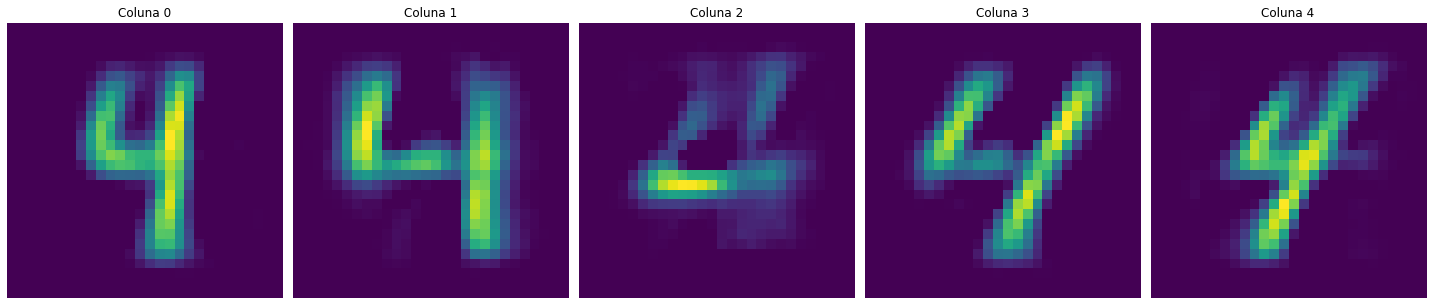

In [61]:
def display_treino(dig,ndig,p,rows,cols):
    with open("dig_treino/W_{}_{}_{}.txt".format(dig,ndig,p)) as file:
        time = file.readline()
        B = np.loadtxt(file)
        display(B,rows,cols)
display_treino(4,1000,5,1,5)

# Palpitômetro

In [ ]:
# Abrindo o caso mais simples 100 e 5
def read_all_digits(ndig_treino, p):
    all_dig = []
    for digito in range(10):
        filename = 'dig_treino/W_{}_{}_{}.txt'.format(digito, ndig_treino, p)
        with open(filename) as f:
            time = f.readline()
            Wd = np.loadtxt(f)
            all_dig.append(Wd)
    return all_dig

In [ ]:
class PPTO: # Palpitômetro
    def __init__(self):
        # abrindo os arquivos
        with open('dados_mnist/test_images.txt') as f:
            self.A = np.loadtxt(f)
        with open('dados_mnist/test_index.txt') as f:
            self.asw = np.loadtxt(f, dtype=np.int8)
        
        # setando variáveis
        self.n, self.m = self.A.shape
        self.p = 0
        
        # vetores auxiliares
        self.D = np.zeros(self.m, dtype=np.int8)
        self.E = np.zeros(self.m)
        
        # todos os erros
        self.all_E = np.zeros((10, self.m))
        self.onde_errou = []

        # setando o contador
        self.count_dig = {}
        for digito in self.asw:
            sdigito = str(digito)
            if sdigito not in self.count_dig:
                self.count_dig[sdigito] = 1
            else:
                self.count_dig[sdigito] += 1

    def MMQS(self, Wds):
        self.n, self.p = Wds[0].shape # todos os 9 Wd's têm a mesma forma (shape)
        num_dig = len(Wds)
        for d in range(num_dig):
            # setando as variáveis
            Wd = Wds[d].copy()
            cpA = self.A.copy()
            
            # resolvendo o sistema simultâneo
            solve_multi(Wd, cpA, self.n, self.m, self.p)
            WH = np.dot(Wds[d], cpA[:self.p,:])
            C = np.subtract(self.A, WH)
            
            # calculando o erro de cada coluna
            for col in range(self.m):
                err = 0.0
                for row in range(self.n):
                    err += (C[row, col])**2
                err = math.sqrt(err)
                
                # coletando todos os erros
                self.all_E[d, col] = err
                
                # gerando os palpites
                if d == 0:
                    self.E[col] = err
                elif err < self.E[col]:
                    self.E[col] = err
                    self.D[col] = d
    
    def generate_report(self, ndig_treino):
        # inicializando o contador de acertos
        correct = 0
        correct_dig = {}
        for num in range(10):
            snum = str(num)
            correct_dig[snum] = 0
        
        # contando os acertos
        for row in range(self.m):
            if self.D[row] == self.asw[row]:
                correct += 1
                correct_dig[str(self.D[row])] += 1
            else:
                self.onde_errou.append(int(row))
            
        # gerando o relatório
        with open('reports/report_{}_{}.txt'.format(ndig_treino, self.p), 'w+') as f:
            f.write('Relatório do caso p = {} e ndig_treino = {}\n\n'.format(self.p, ndig_treino))
            f.write('Percentual total de acertos: {:.2f}%\n\n'.format((correct/self.m)*100))
            
            for dig, right in correct_dig.items():
                f.write('Digito ' + dig + '\n')
                total = self.count_dig[dig]
                f.write('Acertos: {}/{}\n'.format(right, total))
                f.write('Percentual de acertos: {:.2f}%\n\n'.format((right/total)*100))
        
        with open('erros/erros_{}_{}.txt'.format(ndig_treino, self.p), 'w+') as f:
            np.savetxt(f, self.all_E)
        with open('erros/onde_errou_{}_{}.txt'.format(ndig_treino, self.p), 'w+') as f:
            np.savetxt(f, self.onde_errou)

In [ ]:
def palpite_all():
    ndig_treinos = [100, 1000, 4000]
    ps = [5, 10, 15]
    pp = PPTO()

    print('Horário de começo: {}\n'.format(datetime.now().time()))

    for ndig_treino in ndig_treinos:
        for p in ps:
            print('Caso ndig_treino {} com p {}\n'.format(ndig_treino, p))
            start = time.time()

            Wds = read_all_digits(ndig_treino, p)
            pp.MMQS(Wds)

            elapsed_time = (time.time() - start)
            print('Tempo gasto para o MMQ: {}\n'.format(elapsed_time))

            pp.generate_report(ndig_treino)

    print('Acabou às: {}'.format(datetime.now().time()))
palpite_all()

# Gráficos para discussão

In [70]:
def get_data():
    data = [[],[],[]]
    ndig = [100, 1000, 4000]
    ps = [5, 10, 15]

    for x in range(len(ps)):
        for y in range(len(ndig)):
            report = "reports/report_{}_{}.txt".format(ndig[y], ps[x])
            with open(report, "r") as f:
                    lines = f.readlines()
                    data[y].append(float(lines[2][-7:-2]))

    return data[0], data[1], data[2]

In [71]:
def get_data1(ndig, p):
    report = "reports/report_{}_{}.txt".format(ndig, p)
    
    with open(report, "r", encoding="utf-8") as f:
        lines = f.read().replace('\n', ' ')
        matched = re.findall('[0-9]+\.[0-9]+', lines)
        matched = matched[1:]
        for index in range(len(matched)):
            matched[index] = float(matched[index])
        return matched

In [76]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

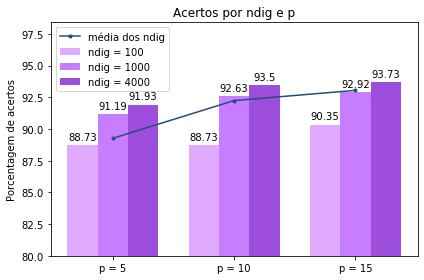

In [77]:
def data_mean(data):
    y = []

    for p in data:
        y.append((p[0] + p[1] + p[2])/3)
    return y

labels = ['p = 5','p = 10','p = 15']
data1, data2, data3 = get_data()

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
y = data_mean([data1, data2, data3])

mean = ax.plot([0,1,2], y,'.-', color='#274c77', label="média dos ndig")

rects1 = ax.bar(x - width, data1, width, label='ndig = 100', fc='#e0aaff')
rects2 = ax.bar(x, data2, width, label='ndig = 1000', fc='#c77dff')
rects3 = ax.bar(x + width, data3, width, label='ndig = 4000', fc='#9d4edd')

ax.set_ylabel('Porcentagem de acertos')
ax.set_title('Acertos por ndig e p')
ax.set_ylim(ymin=80)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=2)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig('figuras/acerto_ndig_p.png', dpi=150)
plt.show()

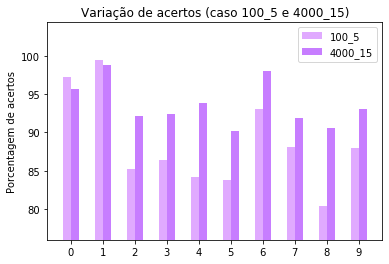

In [79]:
def compare_casos(ndig1, p1, ndig2, p2):
    fig1, ax1 = plt.subplots()

    caso1 = get_data1(ndig1,p1)
    caso2 = get_data1(ndig2,p2)

    labels = ['0','1','2','3','4','5','6','7','8','9']
    x = np.arange(len(labels))  # the label locations
    width = 0.25

    rects1 = ax1.bar(x - width/2, caso1, width, label='{}_{}'.format(ndig1,p1), fc='#e0aaff')
    rects2 = ax1.bar(x + width/2, caso2, width, label='{}_{}'.format(ndig2,p2), fc='#c77dff')

    ax1.set_ylabel('Porcentagem de acertos')
    ax1.set_title('Variação de acertos (caso {}_{} e {}_{})'.format(ndig1, p1, ndig2, p2))
    ax1.set_ylim(ymin=76)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)

    ax1.legend(loc=1)
    plt.savefig('figuras/acertos-{}_{}-{}_{}.png'.format(ndig1, p1, ndig2, p2), dpi=150)
    plt.show()
compare_casos(100, 5, 4000, 15)

In [80]:
# depende dos erros e do onde errou
def get_k_rank(k, ndig, p, digito):
    # inicializa o dicionário
    topk_digitos = {}
    for i in range(1, k+1):
        topk_digitos[i] = {}
        
    with open('dados_mnist/test_index.txt') as f:
        asw = np.loadtxt(f, dtype=np.int8)
    
    erros = np.loadtxt('erros/erros_{}_{}.txt'.format(ndig, p))
    
    with open('erros/onde_errou_{}_{}.txt'.format(ndig, p), "r") as f:
        # iterando pelos erros
        for pos in f.readlines():
            pos = (int(float(pos)))
            d = asw[pos]
            
            if d == digito: # apenas olho para o digito escolhido
                erro_d = {}
                for val in range(10):
                    erro_d[erros[val, pos]] = val    
                erro_d = sorted(erro_d.items()) # ordena os erros
                
                for i in range(0, k):
                    dl = erro_d[i][1]
                    
                    if dl not in topk_digitos[i + 1]: # inicializa os valores
                        topk_digitos[i + 1][dl] = 1
                    else:
                        topk_digitos[i + 1][dl] += 1 # faz o update
        return topk_digitos

In [81]:
def autolabel_deluxe(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [82]:
def plot_top_k(topks, k, ndig, p, digito, preset):
    labels = ['0','1','2','3','4','5','6','7','8','9']
    
    fig, ax = plt.subplots(preset[0], preset[1], figsize=(13,6))
    
    plt.subplots_adjust(top=0.9)
    fig.tight_layout(pad=2.0) # distância entre os plots
    plt.subplots_adjust(hspace=1)
    fig.suptitle('Histogramas do top {} digitos chutados no lugar do {}'.format(k, digito), size=15, y=1.05)
    
    for i in range(k):
        rect = ax[i].bar(list(topks[i + 1].keys()), topks[i + 1].values(), width=0.5, color='#c77dff')
        autolabel_deluxe(rect, ax[i])
        ax[i].set_title('{}º posição'.format(i + 1), size=14)
        
        ax[i].set_ylabel('Frequência', size=14)
        x = np.arange(len(labels))  # the label locations
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(labels)
        
    plt.savefig('figuras/top_{}-digito_{}-{}_{}.png'.format(k, digito, ndig, p), dpi=150)
    plt.show()

In [85]:
def create_top_plots(k=3, ndig=1000, p=10, digito=1, preset=(1,3)): # preset define como dispor as imagens (depende de k)
    topks = get_k_rank(k,ndig,p,digito)
    plot_top_k(topks,k,ndig,p,digito,preset)

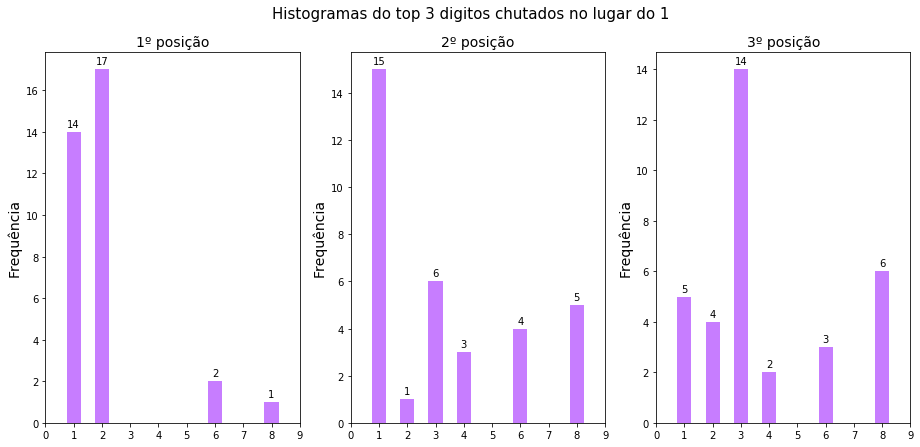

In [86]:
create_top_plots()

## <font color=#C8531A>Apêndice</font>

Os testes foram realizados executando os métodos em estudo em situações cujo resultado é previamente conhecido, seja porque fornecido no documento de referência, porque calculado manualmente e/ou no `Octave`, ou porque evidente. Em todo caso, tal conhecimento "a priori" é aqui disposto acima de cada célula de código do teste.

> Observação: os testes vêm como métodos `teste_X` em virtude do não-compartilhamento (perigoso) de variáveis cujo nome é comumente empregado em demais métodos (e.g., $W$, $A$ etc.).

### <font color=#C81A38>Teste dos métodos da Primeira Tarefa</font>

__Teste de `cos_sin`__

$W =
\begin{pmatrix}
1 & 2 \\
3 & 4
\end{pmatrix}$

$i = 1, j = 2, k = 1 \hspace{1cm} \left( w_{1,1} = 1 < 3 = w_{2,1} \right) \hspace{1cm} \tau = -\frac{w_{1,1}}{w_{2,1}} = -\frac{1}{3}\\
sin = \frac{1}{\sqrt{1 + \tau^{2}}} = \frac{1}{\sqrt{1 + (\frac{1}{3})^{2}}} \approx 0,9486833... \hspace{2cm} cos = \tau sin = - \frac{0,9486833}{3} \approx -0,31622777...$

In [ ]:
def teste_cos_sin():
    W = np.array([[1.0,2.0], 
                  [3.0,4.0]])
    c, s = cos_sin(W, 1, 2, 1)
    print("cos =",c)
    print("sin =",s)
teste_cos_sin()

__Teste de `rot_Givens`__

Exemplo da página 2 do documento de referência.<br>
$Q(3,4,\theta) \cdot W = Q(3,4,\theta) \cdot
\begin{pmatrix}
2 & 1 & 1 & -1 & 1 \\
0 & 3 & 0 & 1 & 2 \\
0 & 0 & 2 & 2 & -1 \\
0 & 0 & -1 & 1 & 2 \\
0 & 0 & 0 & 3 & 1
\end{pmatrix} = 
\begin{pmatrix}
2 & 1 & 1 & -1 & 1 \\
0 & 3 & 0 & 1 & 2 \\
0 & 0 & \frac{5}{\sqrt{5}} & \frac{3}{\sqrt{5}} & -\frac{4}{\sqrt{5}} \\
0 & 0 & 0 & \frac{4}{\sqrt{5}} & \frac{3}{\sqrt{5}} \\
0 & 0 & 0 & 3 & 1
\end{pmatrix} \approx
\begin{pmatrix}
2 & 1 & 1 & -1 & 1 \\
0 & 3 & 0 & 1 & 2 \\
0 & 0 & 2,23606798 & 1,34164079 & -1,78885438 \\
0 & 0 & 0 & 1,78885438 & 1,34164079 \\
0 & 0 & 0 & 3 & 1
\end{pmatrix}$

In [ ]:
def teste_rot_Givens():
    A = np.array([[2.0, 1.0, 1.0,-1.0, 1.0],
                  [0.0, 3.0, 0.0, 1.0, 2.0],
                  [0.0, 0.0, 2.0, 2.0,-1.0],
                  [0.0, 0.0,-1.0, 1.0, 2.0],
                  [0.0, 0.0, 0.0, 3.0, 1.0]])

    cos, sin = cos_sin(A, 3, 4, 3)
    rot_Givens(A, 5, 5, 3, 4, cos, sin)
    print(A)
teste_rot_Givens()

__Teste de `solve`__

(comentar o lance das últimas linhas)

$W \cdot x = b \Rightarrow
\begin{pmatrix}
1 & 2 \\
3 & 4 \\
5 & 6
\end{pmatrix}
\cdot
\begin{pmatrix}
x_{1} \\
x_{2}
\end{pmatrix}
=
\begin{pmatrix}
1 \\
1 \\
1
\end{pmatrix} \Rightarrow
x = 
\begin{pmatrix}
-1 \\
1
\end{pmatrix}
$

In [ ]:
def teste_solve():
    W = np.array([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    b = np.array([[1.0], [1.0], [1.0]])

    solve(W, b, 3, 2)
    print("x =\n",b[0:2,:])
teste_solve()

__Teste de `solve_multi`__

$W \cdot x = A \Rightarrow
\begin{pmatrix}
1 & 2 \\
2 & 1
\end{pmatrix}
\cdot
\begin{pmatrix}
x_{1,1} & x_{1,2} & x_{1,3} \\
x_{2,1} & x_{2,2} & x_{2,3}
\end{pmatrix}
=
\begin{pmatrix}
1 & 2 & 3 \\
4 & 5 & 6
\end{pmatrix} \Rightarrow
x = 
\begin{pmatrix}
\frac{7}{3} & \frac{8}{3} & 3 \\
-\frac{2}{3} & -\frac{1}{3} & 0
\end{pmatrix} \approx
\begin{pmatrix}
2,33333331 & 2,66666664 & 3 \\
-0,66666666 & -0,33333333 & 0
\end{pmatrix} 
$

In [ ]:
def teste_solve_multi():
    W = np.array([[1.0, 2.0], [2.0, 1.0]])
    A = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0]])

    solve_multi(W, A, 2, 3, 2)
    print("x =\n",A)
teste_solve_multi()

### <font color=#C81A38>Teste dos métodos da Segunda Tarefa</font>

__Teste de `erro`__

Exemplo da página 6 do documento de referência (decomposição exata).<br>
$E = \| A - WH  \|^2 = 0$, para <br><br>
$A =
\begin{pmatrix}
\frac{3}{10} & \frac{3}{5} & 0 \\
\frac{1}{2} & 0 & 1 \\
\frac{4}{10} & \frac{4}{5} & 0
\end{pmatrix}, \quad W =
\begin{pmatrix}
\frac{3}{5} & 0 \\
0 & 1 \\
\frac{4}{5} & 0
\end{pmatrix}, \quad H =
\begin{pmatrix}
\frac{1}{2} & 1 & 0 \\
\frac{1}{2} & 0 & 1
\end{pmatrix}$

In [ ]:
def teste_erro():
    A = np.array([[0.3,0.6,0.0],[0.5,0.0,1.0],[0.4,0.8,0.0]])
    W = np.array([[0.6,0.0],[0.0,1.0],[0.8,0.0]])
    H = np.array([[0.5,1.0,0.0],[0.5,0.0,1.0]])
    E = erro(A,W,H,3,3)
    print("E =", E)
teste_erro()

__Teste de `norm`__

Pela definição de normalização, <br>
$normalização \left[ \begin{pmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{pmatrix} \right] = 
\begin{pmatrix}
\frac{1}{\sqrt{66}} & \frac{2}{\sqrt{93}} & \frac{3}{\sqrt{126}} \\
\frac{4}{\sqrt{66}} & \frac{5}{\sqrt{93}} & \frac{6}{\sqrt{126}} \\
\frac{7}{\sqrt{66}} & \frac{8}{\sqrt{93}} & \frac{9}{\sqrt{126}}
\end{pmatrix} \approx
\begin{pmatrix}
0,12309149 & 0,20739034 & 0,26726124 \\
0,49236596 & 0,51847585 & 0,53452248 \\
0,86164043 & 0,82956136 & 0,80178372
\end{pmatrix}$

In [ ]:
def teste_norm():
    W = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]])
    A = norm(W,3,3)
    print("norm(W) =\n",A)
teste_norm()

__Teste de `set_matrix`__

Pela definição deste tipo de matriz (página 5 do documento de referência),<br><br>
$redefinição\left(2,4\right) \left[ \begin{pmatrix}
-1 & 2 & -3 & 4 \\
5 & -6 & 7 & -8 \\
9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16
\end{pmatrix} \right] = 
\begin{pmatrix}
0 & 2 & 0 & 4 \\
5 & 0 & 7 & 0
\end{pmatrix}
$

In [ ]:
def teste_set_matrix():
    A = np.array([[-1.0,2.0,-3.0,4.0],[5.0,-6.0,7.0,-8.0],[9.0,10.0,11.0,12.0],[13.0,14.0,15.0,16.0]])
    B = set_matrix(A,2,4)
    print("B =\n",B)
teste_set_matrix()

__Teste de `NMF`__

Exemplo da página 6 do documento de referência (decomposição exata).
> Observação: Neste caso, em que $\epsilon = 10^{-5}$, a resposta não é exata. Testes aqui omitidos foram feitos com precisão bem maior $\left(\epsilon = 10^{-40} \right)$ e por meio destes obteve-se resultado exato indicado no documento. Isto comprova a eficiência do algoritmo.<br>
Não é de interesse, porém, esse nível de precisão, uma vez que grande parte das matrizes com as quais `NMF` lidará sequer possuem decomposição exata. É por este motivo que o resultado apresentado (assim como todos os demais calculados por este método) tem $\epsilon = 10^{-5}$.

$A = W \cdot H \Rightarrow
\begin{pmatrix}
\frac{3}{10} & \frac{3}{5} & 0 \\
\frac{1}{2} & 0 & 1 \\
\frac{4}{10} & \frac{4}{5} & 0
\end{pmatrix} =
\begin{pmatrix}
\frac{3}{5} & 0 \\
0 & 1 \\
\frac{4}{5} & 0 \\
\end{pmatrix} \cdot
\begin{pmatrix}
\frac{1}{2} & 1 & 0 \\
\frac{1}{2} & 0 & 1
\end{pmatrix} \Rightarrow
W =
\begin{pmatrix}
0,6 & 0 \\
0 & 1 \\
0,8 & 0 \\
\end{pmatrix}, \quad
H =
\begin{pmatrix}
0,5 & 1 & 0 \\
0,5 & 0 & 1
\end{pmatrix}$

In [ ]:
def teste_NMF():
    A = np.array([[0.3,0.6,0.0],[0.5,0.0,1.0],[0.4,0.8,0.0]])
    n = 3
    m = 3
    p = 2
    W, H = NMF(A, n, m, p)
    print("W =\n",W)
    print("H =\n",H)
teste_NMF()

### <font color=#C81A38>Verificação dos resultados pelo Octave dos Testes Sugeridos</font>

Para os __Testes Sugeridos__ da Primeira Tarefa, foi conveniente calcular o que pedido também pelo `Octave`, de modo a poder comparar os resultados. Os resultados destes testes seguem-se a seguir: 

__teste A__<br>
octave:17> inv(W)*b<br>
ans =<br>

    0.492308
    0.015385
    0.476923
    0.030769
    0.461538
    0.046154
    0.446154
    0.061538
    0.430769
    0.076923
    0.415385
    0.092308
    0.400000
    0.107692
    0.384615
    0.123077
    0.369231
    0.138462
    0.353846
    0.153846
    0.338462
    0.169231
    0.323077
    0.184615
    0.307692
    0.200000
    0.292308
    0.215385
    0.276923
    0.230769
    0.261538
    0.246154
    0.246154
    0.261538
    0.230769
    0.276923
    0.215385
    0.292308
    0.200000
    0.307692
    0.184615
    0.323077
    0.169231
    0.338462
    0.153846
    0.353846
    0.138462
    0.369231
    0.123077
    0.384615
    0.107692
    0.400000
    0.092308
    0.415385
    0.076923
    0.430769
    0.061538
    0.446154
    0.046154
    0.461538
    0.030769
    0.476923
    0.015385
    0.492308

__teste B__<br>
octave:6> x = linsolve(W,b)<br>
x =<br>

    56.358
    -45.875
    -43.489
    -48.577
    -30.140
    89.812
    48.714
    59.239
    11.446
    109.163
    -72.873
    -54.363
    -51.444
    -25.015
    98.572
    218.659
    298.400

__teste C__<br>
octave:14> inv(W)*A<br>
ans =<br>

     0   -32   -64
     1     1     2
     1    34    68
     0     2     4
     0   -30   -60
     1     3     6
     1    36    72
     0     4     8
     0   -28   -56
     1     5    10
     1    38    76
     0     6    12
     0   -26   -52
     1     7    14
     1    40    80
     0     8    16
     0   -24   -48
     1     9    18
     1    42    84
     0    10    20
     0   -22   -44
     1    11    22
     1    44    88
     0    12    24
     0   -20   -40
     1    13    26
     1    46    92
     0    14    28
     0   -18   -36
     1    15    30
     1    48    96
     0    16    32
     0   -16   -32
     1    17    34
     1    50   100
     0    18    36
     0   -14   -28
     1    19    38
     1    52   104
     0    20    40
     0   -12   -24
     1    21    42
     1    54   108
     0    22    44
     0   -10   -20
     1    23    46
     1    56   112
     0    24    48
     0    -8   -16
     1    25    50
     1    58   116
     0    26    52
     0    -6   -12
     1    27    54
     1    60   120
     0    28    56
     0    -4    -8
     1    29    58
     1    62   124
     0    30    60
     0    -2    -4
     1    31    62
     1    64   128
     0    32    64
     
__teste D__<br>
octave:9> x = linsolve (W,A)<br>
x =<br>

     2.88155    56.35781   112.71562
    -1.83376   -45.87485   -91.74970
    -1.51399   -43.48902   -86.97805
    -1.52191   -48.57655   -97.15310
    -0.45379   -30.14020   -60.28040
     5.85670    89.81212   179.62424
     3.42193    48.71365    97.42730
     3.65656    59.23925   118.47849
     1.20368    11.44636    22.89271
     6.12534   109.16274   218.32547
    -2.47971   -72.87275  -145.74551
    -1.47793   -54.36289  -108.72579
    -1.20390   -51.44442  -102.88883
     0.12841   -25.01481   -50.02963
     6.50159    98.57194   197.14388
    11.49106   218.65886   437.31772
    14.58053   298.40023   596.80046
